In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import torch
import numpy as np
import pandas as pd
import json
import cv2
import pickle
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
import torchvision
from CTImageQuality.models.edcnn import EDCNN
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt

In [40]:
# load images

lables_path = 'data/LDCTIQAG2023_train/train.json'
images_dir = 'data/LDCTIQAG2023_train/image'

def load_images(data):
    
    image_np = list()
    for name,val in data.items():
        img = cv2.imread(f'{images_dir}/{name}', cv2.IMREAD_UNCHANGED)
        image_np.append(img)
    return np.stack(image_np)

with open(lables_path) as file:
    all_lables = pd.Series(json.load(file))
    
all_images = load_images(all_lables)
train_sz = 880
train_lables, test_lables = all_lables[:train_sz], all_lables[train_sz:]
train_images, test_images = all_images[:train_sz], all_images[train_sz:]

In [41]:
class PairDS(torch.utils.data.IterableDataset):
    def __init__(self, images, lables):
        self.images = images
        self.lables = lables

    def __iter__(self):
        self.unused = np.arange(0, self.images.shape[0])
        np.random.shuffle(self.unused)
        self.unused = iter(np.reshape(self.unused,(-1,2)))
        return self.generator()
    
    def generator(self):
        for ind1, ind2 in self.unused:
            diff = self.lables.iloc[ind1] - self.lables.iloc[ind2]

            yield self.images[ind1][np.newaxis], self.images[ind2][np.newaxis], diff

In [42]:
class HydraModel(nn.Module):
    def __init__(self, backbone, vector_size=1000):
        super().__init__()
        self.backbone = backbone
        self.fc1 = nn.Linear(vector_size*2, 200) 
        self.fc2 = nn.Linear(200, 1) 
    
    def forward(self, x):
        im1, im2 = x
        vec1 = self.backbone(im1)
        vec2 = self.backbone(im2)
        
        combined = torch.cat((vec1, vec2),dim=1)
        x = self.fc1(combined)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        
        return x

In [43]:

back = torchvision.models.resnet18()
back.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
edcnn = EDCNN()
weigths = torch.load('weights/edcnn.pkl', map_location=torch.device("cuda"))
edcnn.load_state_dict(weigths)
nnet = HydraModel(back)#cnn)
nnet.train()
nnet.cuda()
pds = PairDS(all_images, all_lables)
lld = DataLoader(pds,batch_size=10)
optimizer = torch.optim.AdamW(nnet.parameters(), lr=0.001)

In [58]:
def put_images_to_locations(model, test_images):
    model.eval()
    model_tensor = next(model.parameters())
    unprocessed = iter(np.expand_dims(test_images,1))
    processed = [next(unprocessed)]
    results = [0]
    with torch.no_grad():
        for i,img in tqdm(enumerate(unprocessed)):
            # Calculate relative position to every other image
            processed_batched = DataLoader(processed,batch_size=64)
            tensor_img = torch.unsqueeze(torch.from_numpy(img).to(model_tensor), 0)
            relative_weights = list()
            for batch in processed_batched:
                matching_img = torch.broadcast_to(tensor_img, batch.shape)
                relative_weights.append(model((matching_img, batch.to(model_tensor))))
            processed.append(img)
            relative_weights=torch.squeeze(torch.cat(relative_weights))
            res = torch.tensor(results)+relative_weights.cpu()
            results.append(res.mean().item())
    model.train()
    return results

def validate_vector(total_pred, total_gt):
    aggregate_results=dict()
    aggregate_results["plcc"] = abs(pearsonr(total_pred, total_gt)[0])
    aggregate_results["srocc"] = abs(spearmanr(total_pred, total_gt)[0])
    aggregate_results["krocc"] = abs(kendalltau(total_pred, total_gt)[0])
    aggregate_results["overall"] = abs(pearsonr(total_pred, total_gt)[0]) + abs(spearmanr(total_pred, total_gt)[0]) + abs(kendalltau(total_pred, total_gt)[0])
    return aggregate_results

# res = put_images_to_locations(nnet, test_images)

In [62]:
0%3==0

True

In [63]:
for epoch in range(35):
    if epoch%7==0:
        res = put_images_to_locations(nnet, test_images)
        print(f'Validation score: {validate_vector(res,test_lables.values)}')
    log = tqdm(enumerate(lld))
    torch.save(nnet.state_dict(), 'hydra_point.pth')
    for i, data in log:
        model_tensor = next(nnet.parameters())
        im1, im2, target = (x.to(model_tensor) for x in data)
        pred = nnet((im1,im2))
        loss = F.mse_loss(pred.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itm = loss.item()
        if i==0:
            losser = itm
        losser = losser*0.9+itm*0.1
        log.set_postfix({"loss": losser})

119it [00:29,  4.08it/s]


Validation score: {'plcc': 0.9001068734453547, 'srocc': 0.918165834777437, 'krocc': 0.7672458490378625, 'overall': 2.585518557260654}


50it [00:07,  6.67it/s, loss=0.548]
50it [00:07,  6.66it/s, loss=0.513]
50it [00:07,  6.69it/s, loss=0.633]
50it [00:07,  6.70it/s, loss=0.482]
50it [00:07,  6.71it/s, loss=0.443]
50it [00:07,  6.68it/s, loss=0.467]
50it [00:07,  6.69it/s, loss=0.501]
119it [00:29,  4.08it/s]


Validation score: {'plcc': 0.9552388958558873, 'srocc': 0.9572538934276825, 'krocc': 0.8379226806661396, 'overall': 2.7504154699497096}


50it [00:07,  6.68it/s, loss=0.352]
50it [00:07,  6.60it/s, loss=0.508]
50it [00:07,  6.65it/s, loss=0.309]
50it [00:07,  6.69it/s, loss=0.389]
50it [00:07,  6.70it/s, loss=0.413]
50it [00:07,  6.65it/s, loss=0.293]
50it [00:07,  6.64it/s, loss=0.273]
119it [00:29,  4.08it/s]


Validation score: {'plcc': 0.7367096136484179, 'srocc': 0.7905660747887977, 'krocc': 0.609228542551877, 'overall': 2.1365042309890927}


50it [00:07,  6.66it/s, loss=0.315]
50it [00:07,  6.65it/s, loss=0.318]
50it [00:07,  6.64it/s, loss=0.219]
50it [00:07,  6.65it/s, loss=0.297]
50it [00:07,  6.63it/s, loss=0.243]
50it [00:07,  6.68it/s, loss=0.312]
50it [00:07,  6.69it/s, loss=0.35] 
119it [00:29,  4.08it/s]


Validation score: {'plcc': 0.9595355748796099, 'srocc': 0.9602769908793614, 'krocc': 0.8433814603447465, 'overall': 2.763194026103718}


50it [00:07,  6.64it/s, loss=0.316]
50it [00:07,  6.66it/s, loss=0.289]
50it [00:07,  6.68it/s, loss=0.296]
50it [00:07,  6.69it/s, loss=0.244]
50it [00:07,  6.68it/s, loss=0.339]
50it [00:07,  6.63it/s, loss=0.239]
50it [00:07,  6.69it/s, loss=0.265]
119it [00:29,  4.07it/s]


Validation score: {'plcc': 0.9297653024323013, 'srocc': 0.9486159751624138, 'krocc': 0.8178113871133779, 'overall': 2.696192664708093}


50it [00:07,  6.68it/s, loss=0.278]
50it [00:07,  6.63it/s, loss=0.249]
50it [00:07,  6.64it/s, loss=0.262]
50it [00:07,  6.64it/s, loss=0.229]
50it [00:07,  6.65it/s, loss=0.194]
50it [00:07,  6.67it/s, loss=0.213]
50it [00:07,  6.66it/s, loss=0.202]


In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

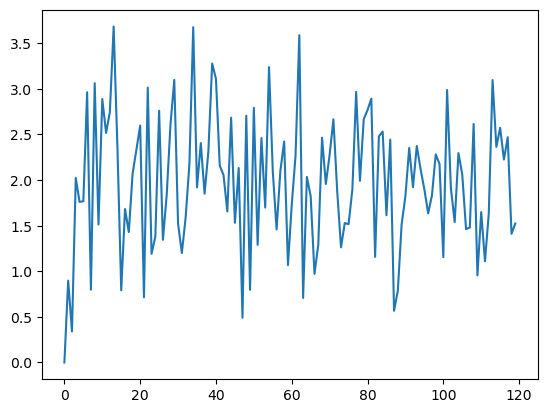

In [67]:
plt.plot(res)